In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
import os
from PIL import Image

In [5]:
dataset_folder = '/content/drive/MyDrive/Tyre Quality'
img_path = '/content/drive/MyDrive/Tyre Quality/training/defective/Defective (1).jpg'
training_dataset_path = '/content/drive/MyDrive/Tyre Quality/training'
testing_dataset_path = '/content/drive/MyDrive/Tyre Quality/testing'
classes = sorted(os.listdir(dataset_folder + '/training'))

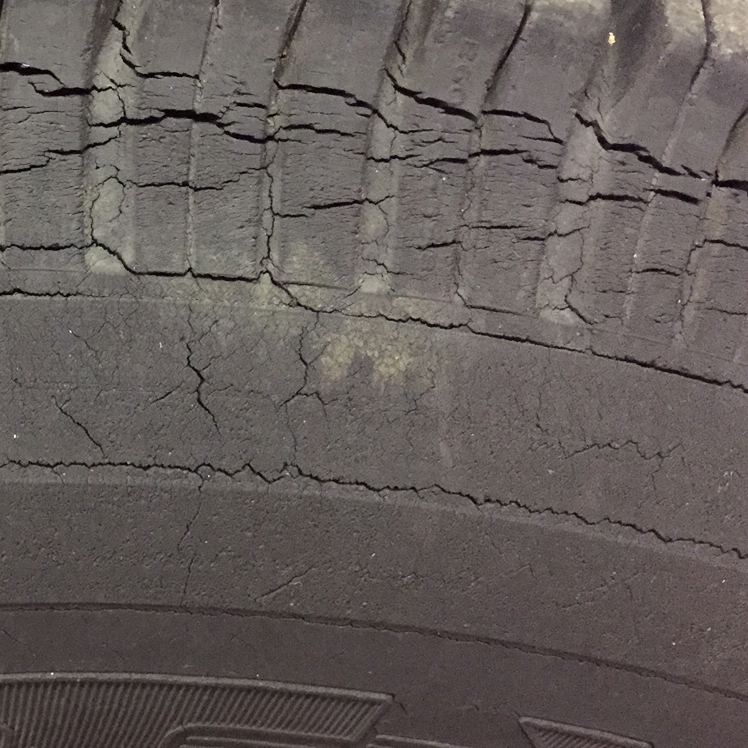

In [6]:
img = Image.open(img_path)
img

In [7]:
classes

['defective', 'good']

In [8]:
import numpy as np

In [9]:
np.random.seed(0)
torch.manual_seed(0)

In [10]:
from PIL import ImageOps, ImageFilter
import torchvision.transforms.functional as F
from torchvision import transforms

In [45]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match your number of classes
num_classes = 2  # Replace with your actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True


In [47]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Tyre Quality/training', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Tyre Quality/testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [48]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer, only update the parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [50]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 3  # Adjust based on your dataset size

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Epoch 1/3, Loss: 0.35074768717191657
Validation Accuracy: 88.72%
Epoch 2/3, Loss: 0.2909035126165468
Validation Accuracy: 89.49%
Epoch 3/3, Loss: 0.24915103173377562
Validation Accuracy: 90.51%


In [51]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Tyre Quality/fine_tuned_resnet.pth')

In [52]:
import torch.nn as nn

# Remove the final fully connected layer for feature extraction
feature_extractor = nn.Sequential(*list(model.children())[:-1])

In [53]:
import torch

def extract_features(loader, model, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Forward pass through the feature extractor
            features = model(inputs)
            features = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features.cpu())
            labels_list.append(labels)
    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    return features, labels

In [54]:
# Assuming your model is on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Extract features for the training and validation sets
train_features, train_labels = extract_features(train_loader, feature_extractor, device)
val_features, val_labels = extract_features(val_loader, feature_extractor, device)


In [55]:
import numpy as np

# Convert to numpy arrays for easier saving and processing
train_features = train_features.numpy()
train_labels = train_labels.numpy()
val_features = val_features.numpy()
val_labels = val_labels.numpy()

# Save features and labels
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('val_features.npy', val_features)
np.save('val_labels.npy', val_labels)


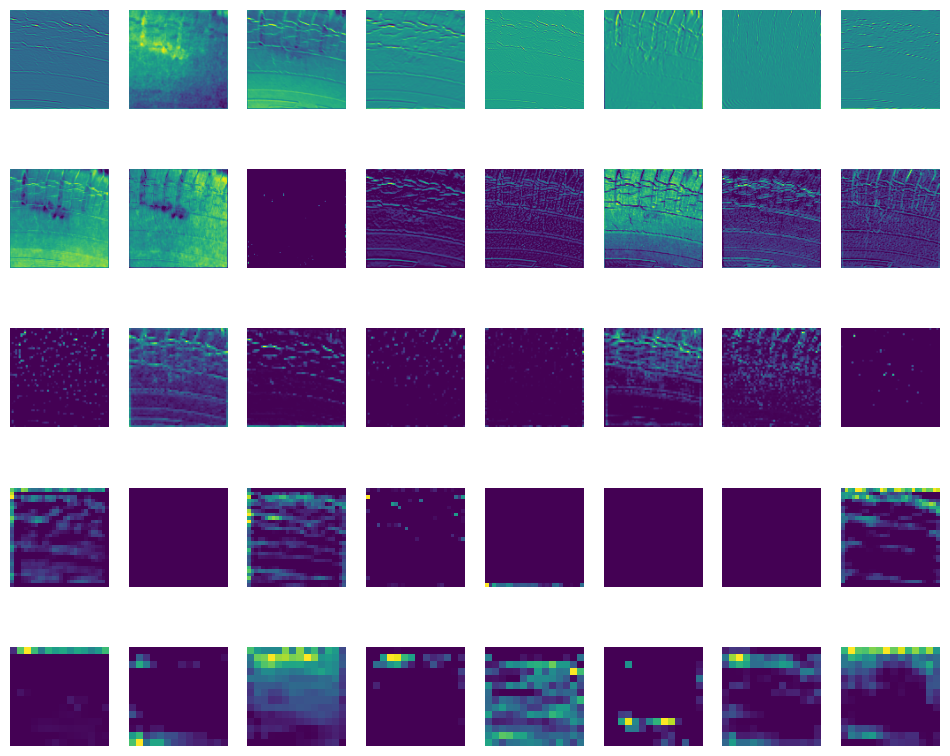

In [56]:
import torch
import matplotlib.pyplot as plt

# Function to visualize feature maps at specific blocks in ResNet
def visualize_feature_maps(model, image, blocks=['conv1', 'layer1', 'layer2', 'layer3', 'layer4']):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image = image.to(device)

    fig, axes = plt.subplots(len(blocks), 8, figsize=(12, len(blocks) * 2))
    x = image.unsqueeze(0)  # Add batch dimension

    # Pass through each block and visualize the output
    for idx, block_name in enumerate(blocks):
        # Forward pass through the block
        x = getattr(model, block_name)(x)

        # Visualize the first 8 feature maps of the current block
        for i in range(8):
            ax = axes[idx, i]
            feature_map = x[0, i].detach().cpu().numpy()
            ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
        axes[idx, 0].set_ylabel(f'{block_name}')

    plt.show()

# Example usage:
# Assuming `img` is your preprocessed image tensor (e.g., from a PIL image)
img_tensor = image_transform()(img)  # Ensure your image is preprocessed
visualize_feature_maps(model, img_tensor)


In [57]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load features (if saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an SVM classifier
svm = SVC()
svm.fit(train_features, train_labels)

# Evaluate the classifier on validation features
val_predictions = svm.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")


Validation Accuracy with SVM: 95.90%


In [58]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an SVM classifier with probability estimates enabled
svm = SVC(probability=True)
svm.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = svm.predict(val_features)
val_pred_proba = svm.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with SVM: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"SVM Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"SVM Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"SVM Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"SVM Classification Precision: {precision:.2f}")
print(f"SVM Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with SVM: 95.90%
SVM Classification Log Loss: 0.1249
SVM Classification F1 Score: 0.96
SVM Classification AUC: 0.99
SVM Classification Precision: 0.96
SVM Classification Recall: 0.96
Metric         : Value
Accuracy       : 95.90%
F1 Score       : 0.96
AUC            : 0.99
Log Loss       : 0.1249
Precision      : 0.96
Recall         : 0.96


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a RandomForestClassifier with probability estimates enabled
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = rf_classifier.predict(val_features)
val_pred_proba = rf_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with Random Forest: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"Random Forest Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"Random Forest Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"Random Forest Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"Random Forest Classification Precision: {precision:.2f}")
print(f"Random Forest Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with Random Forest: 91.54%
Random Forest Classification Log Loss: 0.3010
Random Forest Classification F1 Score: 0.92
Random Forest Classification AUC: 0.98
Random Forest Classification Precision: 0.92
Random Forest Classification Recall: 0.92
Metric         : Value
Accuracy       : 91.54%
F1 Score       : 0.92
AUC            : 0.98
Log Loss       : 0.3010
Precision      : 0.92
Recall         : 0.92


In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_features, train_labels)

# Predict class labels for validation features
val_predictions = knn_classifier.predict(val_features)

# Check if predict_proba is available (only if `n_neighbors` > 1 and the classifier is suitable)
if hasattr(knn_classifier, "predict_proba"):
    val_pred_proba = knn_classifier.predict_proba(val_features)
    # Calculate Log Loss
    loss = log_loss(val_labels, val_pred_proba)
    print(f"KNN Classification Log Loss: {loss:.4f}")
else:
    val_pred_proba = None
    loss = None
    print("Log Loss not available for KNN without probability estimates.")

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with KNN: {accuracy * 100:.2f}%")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"KNN Classification F1 Score: {f1:.2f}")

# Calculate AUC Score (only if probabilities are available)
if val_pred_proba is not None:
    if len(set(val_labels)) > 2:
        lb = LabelBinarizer()
        val_labels_binarized = lb.fit_transform(val_labels)
        auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
    else:
        auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
    print(f"KNN Classification AUC: {auc:.2f}")
else:
    auc = None
    print("AUC not available for KNN without probability estimates.")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"KNN Classification Precision: {precision:.2f}")
print(f"KNN Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = [
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["Log Loss", f"{loss:.4f}" if loss is not None else "N/A"],
    ["AUC", f"{auc:.2f}" if auc is not None else "N/A"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
]

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


KNN Classification Log Loss: 0.1418
Validation Accuracy with KNN: 94.62%
KNN Classification F1 Score: 0.95
KNN Classification AUC: 0.99
KNN Classification Precision: 0.95
KNN Classification Recall: 0.95
Metric         : Value
Accuracy       : 94.62%
F1 Score       : 0.95
Log Loss       : 0.1418
AUC            : 0.99
Precision      : 0.95
Recall         : 0.95


In [61]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = xgb_classifier.predict(val_features)
val_pred_proba = xgb_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with XGBoost: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"XGBoost Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"XGBoost Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"XGBoost Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"XGBoost Classification Precision: {precision:.2f}")
print(f"XGBoost Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy with XGBoost: 92.56%
XGBoost Classification Log Loss: 0.1698
XGBoost Classification F1 Score: 0.93
XGBoost Classification AUC: 0.98
XGBoost Classification Precision: 0.93
XGBoost Classification Recall: 0.93
Metric         : Value
Accuracy       : 92.56%
F1 Score       : 0.93
AUC            : 0.98
Log Loss       : 0.1698
Precision      : 0.93
Recall         : 0.93


In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train a GaussianNB classifier
gnb_classifier = GaussianNB()
gnb_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = gnb_classifier.predict(val_features)
val_pred_proba = gnb_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with GaussianNB: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"GaussianNB Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"GaussianNB Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"GaussianNB Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"GaussianNB Classification Precision: {precision:.2f}")
print(f"GaussianNB Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with GaussianNB: 85.38%
GaussianNB Classification Log Loss: 4.6808
GaussianNB Classification F1 Score: 0.85
GaussianNB Classification AUC: 0.91
GaussianNB Classification Precision: 0.86
GaussianNB Classification Recall: 0.85
Metric         : Value
Accuracy       : 85.38%
F1 Score       : 0.85
AUC            : 0.91
Log Loss       : 4.6808
Precision      : 0.86
Recall         : 0.85


In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, f1_score, roc_auc_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Load features (assuming saved and loaded from files)
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')

# Train an MLPClassifier with probability estimates enabled
mlp_classifier = MLPClassifier(random_state=42, max_iter=300)
mlp_classifier.fit(train_features, train_labels)

# Predict probabilities and class labels for validation features
val_predictions = mlp_classifier.predict(val_features)
val_pred_proba = mlp_classifier.predict_proba(val_features)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with MLP: {accuracy * 100:.2f}%")

# Calculate Log Loss
loss = log_loss(val_labels, val_pred_proba)
print(f"MLP Classification Log Loss: {loss:.4f}")

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions, average='weighted')
print(f"MLP Classification F1 Score: {f1:.2f}")

# Calculate AUC Score
if len(set(val_labels)) > 2:
    lb = LabelBinarizer()
    val_labels_binarized = lb.fit_transform(val_labels)
    auc = roc_auc_score(val_labels_binarized, val_pred_proba, average="weighted", multi_class="ovr")
else:
    auc = roc_auc_score(val_labels, val_pred_proba[:, 1])
print(f"MLP Classification AUC: {auc:.2f}")

# Calculate Precision and Recall
precision = precision_score(val_labels, val_predictions, average='weighted')
recall = recall_score(val_labels, val_predictions, average='weighted')
print(f"MLP Classification Precision: {precision:.2f}")
print(f"MLP Classification Recall: {recall:.2f}")

# Summary in Matrix Form
metrics_matrix = np.array([
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["F1 Score", f"{f1:.2f}"],
    ["AUC", f"{auc:.2f}"],
    ["Log Loss", f"{loss:.4f}"],
    ["Precision", f"{precision:.2f}"],
    ["Recall", f"{recall:.2f}"]
])

# Display metrics matrix
for row in metrics_matrix:
    print(f"{row[0]:<15}: {row[1]}")


Validation Accuracy with MLP: 93.59%
MLP Classification Log Loss: 0.2565
MLP Classification F1 Score: 0.94
MLP Classification AUC: 0.98
MLP Classification Precision: 0.94
MLP Classification Recall: 0.94
Metric         : Value
Accuracy       : 93.59%
F1 Score       : 0.94
AUC            : 0.98
Log Loss       : 0.2565
Precision      : 0.94
Recall         : 0.94
